## Pop Music Classifier - Feed Forward Neural Network
by Kyle Furey and Dhruv Solanki

In [70]:
# Import key libraries
%matplotlib inline
import pandas as pd
import numpy as np
import re
from sklearn import model_selection as skms  # Training testing split
from sklearn import preprocessing as skp  # Scaler
from sklearn import metrics as skm  # Confusion matrix + ROC curve
from sklearn.utils import class_weight
from tensorflow import keras as tfk
from tensorflow.keras import activations as tfka  # Activation functions
from tensorflow.keras import regularizers as tfkr  # Regularization functions
from tensorflow.keras import optimizers as tfko  # Optimizers
from tensorflow.keras import losses as tfkl  # Binary cross-entropy
from tensorflow.keras import metrics as tfkm  # Binary accuracy
from tensorflow.keras import callbacks as tfkc  # Early stopping
import matplotlib.pyplot as plt
import itertools  # Grid search


In [71]:
# Define constants
csv = "/Users/dhruvsolanki/Downloads/Kyle_solanki/music_skip_combined.csv"
data = pd.read_csv(csv)  # Dataset from CSV
full_batch = len(data)  # Full batch size

target_column = "is_pop_genre"
pop_keyword_patterns = [
    r"\bpop\b",
    r"dance[- ]?pop",
    r"electro[- ]?pop",
    r"synth[- ]?pop",
    r"bubblegum",
    r"teen pop",
    r"pop rock",
    r"pop rap",
    r"latin pop",
    r"indie pop",
    r"k[- ]?pop",
    r"j[- ]?pop",
    r"c[- ]?pop"
]

genre_family_keywords = {
    "pop": ["pop", "dance", "bubblegum", "teen"],
    "rock": ["rock", "punk", "metal", "grunge"],
    "hiphop": ["hip hop", "rap", "drill", "trap"],
    "electronic": ["house", "techno", "trance", "edm", "electro"],
    "folk": ["folk", "americana", "bluegrass", "country"],
    "jazz": ["jazz", "swing", "bebop", "ragtime"],
    "classical": ["classical", "symphony", "orchestra", "opera", "choir"],
    "world": ["latin", "cumbia", "salsa", "reggae", "afro", "arab", "indian", "celtic"]
}

numeric_features = [
    "song_length_sec",
    "tempo_bpm",
    "popularity_score",
    "is_explicit",
    "user_liked_previous_song",
    "skipped"
]
categorical_features = ["time_of_day", "genre_family"]
all_features = numeric_features + categorical_features

default_layers = [16, 8]  # Each hidden layer and its node count


In [72]:
def detect_pop_label(genre_text, tags_text):
    text = f"{genre_text} {tags_text}".lower()
    return int(any(re.search(pattern, text) for pattern in pop_keyword_patterns))


def assign_genre_family(genre_text, tags_text):
    text = f"{genre_text} {tags_text}".lower()
    for family, keywords in genre_family_keywords.items():
        if any(keyword in text for keyword in keywords):
            return family
    return "other"



In [73]:
def prepare_dataset(base_features, fill_na=True):
    """Clone the dataset, engineer labels/features, and return processed frame plus feature cols."""
    frame = data.copy()
    frame[target_column] = frame.apply(lambda row: detect_pop_label(row.get("genre", ""), row.get("tags", "")), axis=1)
    frame["genre_family"] = frame.apply(lambda row: assign_genre_family(row.get("genre", ""), row.get("tags", "")), axis=1)

    numeric_cols = [col for col in base_features if col in numeric_features]
    if fill_na:
        for feature in numeric_cols:
            frame[feature].fillna(frame[feature].median(), inplace=True)
    else:
        frame.dropna(subset=numeric_cols, inplace=True)

    for col in ["is_explicit", "user_liked_previous_song", "skipped"]:
        if col in frame.columns:
            frame[col] = frame[col].astype(int)

    frame = pd.get_dummies(frame, columns=[col for col in categorical_features if col in frame.columns], drop_first=False)

    processed_features = []
    for feature in numeric_cols:
        if feature in frame.columns:
            processed_features.append(feature)

    for cat in categorical_features:
        prefix = f"{cat}_"
        processed_features.extend([col for col in frame.columns if col.startswith(prefix)])

    processed_features = sorted(set(processed_features))
    return frame, processed_features



In [74]:
def split_scaled_sets(frame, features, training, validation, testing):
    """Split the data into train/val/test sets and return scaled matrices plus targets."""
    x_raw = frame[features].values
    y_raw = frame[target_column].values

    x_train, x_temp, y_train, y_temp = skms.train_test_split(
        x_raw,
        y_raw,
        train_size=training,
        random_state=42,
        stratify=y_raw
    )

    validate_ratio = validation / (validation + testing)
    x_validate, x_test, y_validate, y_test = skms.train_test_split(
        x_temp,
        y_temp,
        train_size=validate_ratio,
        random_state=42,
        stratify=y_temp
    )

    scaler = skp.StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_validate = scaler.transform(x_validate)
    x_test = scaler.transform(x_test)

    return {
        "x_train": x_train,
        "x_validate": x_validate,
        "x_test": x_test,
        "y_train": y_train,
        "y_validate": y_validate,
        "y_test": y_test
    }



In [75]:
def build_ffnn(input_dim, hidden_layers, activation, regularization, regularization_rate, learning_rate):
    """Create and compile a Sequential FFNN for binary classification."""
    input_layer = tfk.layers.Input(shape=(input_dim,))
    layers = [input_layer]

    for nodes in hidden_layers:
        layers.append(tfk.layers.Dense(
            units=nodes,
            activation=activation,
            kernel_regularizer=regularization(regularization_rate)
        ))

    layers.append(tfk.layers.Dense(1, activation=tfka.sigmoid))

    model = tfk.Sequential(layers)
    model.compile(
        optimizer=tfko.Adam(learning_rate=learning_rate),
        loss=tfkl.BinaryCrossentropy(),
        metrics=[tfkm.BinaryAccuracy()]
    )
    return model



In [76]:
# Define a function for testing the FFNN.
# Returns history, results, training loss, training accuracy, testing loss, and testing accuracy.
def build_music_nn(
        # Define hyperparameters
        name="Default",  # Name of NN
        training=0.6,  # Percent of training data
        testing=0.2,  # Percent of testing data
        validation=0.2,  # Percent of validation data
        mini_batch_size=32,  # Size of mini-batch
        features=None,  # Each enabled feature
        learning_rate=0.001,  # Rate of learning
        activation=tfka.relu,  # Activation function
        regularization=tfkr.l2,  # Regularization function
        regularization_rate=0.001,  # Rate of regularization
        hidden_layers=None,  # Number of hidden layers + # of nodes
        epoch_cap=200,  # Maximum accumulated epoch
        epoch_time=20,  # Minimum epoch
        early_stop=True,  # Early stopping enabled?
        fill_na=True,  # Fill N/A with median and mode (true) or drop it entirely (false)?
        loss=True,  # Display a graph of training and test loss?
        matrix=True,  # Display a confusion matrix?
        roc=True,  # Display a ROC curve?
):
    print("Music FFNN -", name, "\n")

    if features is None:
        features = all_features.copy()
    if hidden_layers is None:
        hidden_layers = default_layers.copy()

    frame, processed_features = prepare_dataset(features, fill_na=fill_na)
    splits = split_scaled_sets(frame, processed_features, training, validation, testing)
    model = build_ffnn(
        input_dim=len(processed_features),
        hidden_layers=hidden_layers,
        activation=activation,
        regularization=regularization,
        regularization_rate=regularization_rate,
        learning_rate=learning_rate
    )

    callbacks = []
    if early_stop:
        callbacks.append(tfkc.EarlyStopping(
            monitor="val_loss",
            min_delta=0.001,
            patience=epoch_time,
            restore_best_weights=True
        ))

    class_weights = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=np.unique(splits["y_train"]),
        y=splits["y_train"]
    )
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(splits["y_train"]), class_weights)}

    print("Training . . .")
    results = model.fit(
        splits["x_train"],
        splits["y_train"],
        validation_data=(splits["x_validate"], splits["y_validate"]),
        epochs=epoch_cap,
        batch_size=mini_batch_size,
        callbacks=callbacks,
        verbose=False,
        class_weight=class_weight_dict
    )
    print("Finished After     : ", len(results.history["loss"]), "epochs")

    training_loss = results.history["loss"][-1]
    training_accuracy = results.history["binary_accuracy"][-1]
    print("Training Accuracy  : ", round(training_accuracy, 3))

    print("\nTesting . . .")
    testing_loss, testing_accuracy = model.evaluate(splits["x_test"], splits["y_test"], verbose=False)
    print("Testing Accuracy   : ", round(testing_accuracy, 3))
    print("\nEvaluation . . .")
    print("Testing Loss       : ", round(testing_loss, 3))
    print("Training Loss      : ", round(training_loss, 3))
    if testing_loss > training_loss:
        print("Overfitting        : ", round(testing_loss - training_loss, 3))
    else:
        print("Overfitting        :  0.0")
    print(" ")

    y_prob = model.predict(splits["x_test"])
    y_predict = (y_prob > 0.5)

    if loss:
        plt.plot(results.history['loss'], label='Training Loss')
        plt.plot(results.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs')
        plt.legend()
        plt.show()

    if matrix:
        matrix_display = skm.confusion_matrix(splits["y_test"], y_predict)
        matrix_display = skm.ConfusionMatrixDisplay(confusion_matrix=matrix_display, display_labels=["Not Pop", "Pop"])
        matrix_display.plot()
        plt.title("Confusion Matrix")
        plt.show()

    if roc:
        print(" ")
        false_positive, true_positive, _ = skm.roc_curve(splits["y_test"], y_prob)
        auc = skm.auc(false_positive, true_positive)
        plt.figure()
        plt.plot(false_positive, true_positive, label=("ROC Curve - Area = " + str(round(auc, 3))))
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive")
        plt.ylabel("True Positive")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    print("\n\n")
    return results, training_loss, training_accuracy, testing_loss, testing_accuracy


In [77]:
from sklearn.ensemble import RandomForestClassifier

def evaluate_random_forest(name="Random Forest", features=None, training=0.6, testing=0.2, validation=0.2):
    if features is None:
        features = all_features.copy()

    frame, processed_features = prepare_dataset(features, fill_na=True)
    splits = split_scaled_sets(frame, processed_features, training, validation, testing)

    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    )

    rf.fit(splits["x_train"], splits["y_train"])
    y_prob = rf.predict_proba(splits["x_test"])[:, 1]
    y_pred = (y_prob > 0.5).astype(int)

    print(f"{name} Accuracy : {skm.accuracy_score(splits['y_test'], y_pred):.3f}")
    print(skm.classification_report(splits["y_test"], y_pred, target_names=["Not Pop", "Pop"]))

    false_positive, true_positive, _ = skm.roc_curve(splits["y_test"], y_prob)
    auc = skm.auc(false_positive, true_positive)
    plt.figure()
    plt.plot(false_positive, true_positive, label=(f"ROC Curve - Area = {auc:.3f}"))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive")
    plt.ylabel("True Positive")
    plt.title(f"{name} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return auc



Music FFNN - FFNN - 60/35/5 split 

Training . . .


/var/folders/01/gv5k9r0x4lx4gqkn4nd4vkbw0000gn/T/ipykernel_58654/1084359367.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  frame[feature].fillna(frame[feature].median(), inplace=True)


Finished After     :  41 epochs
Training Accuracy  :  0.982

Testing . . .
Testing Accuracy   :  0.986

Evaluation . . .
Testing Loss       :  0.1
Training Loss      :  0.072
Overfitting        :  0.028
 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


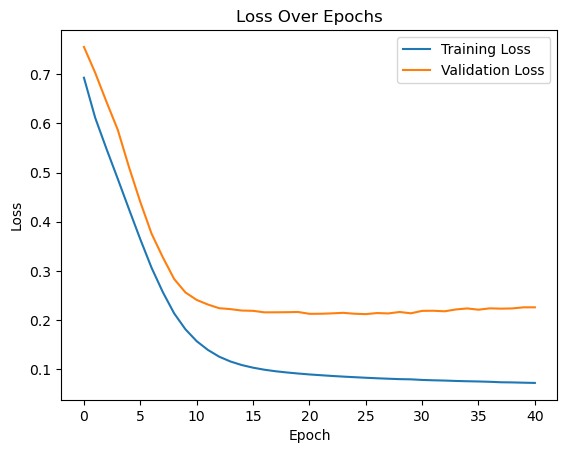

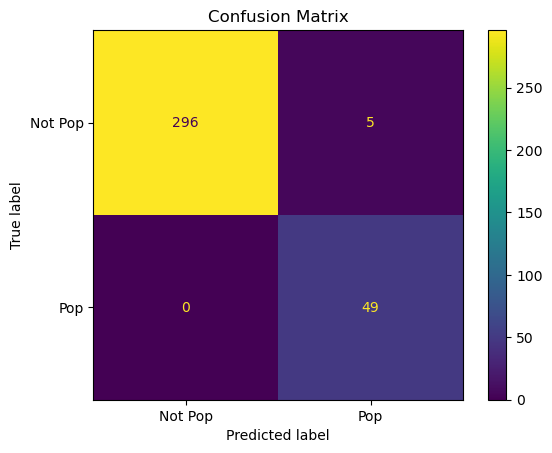

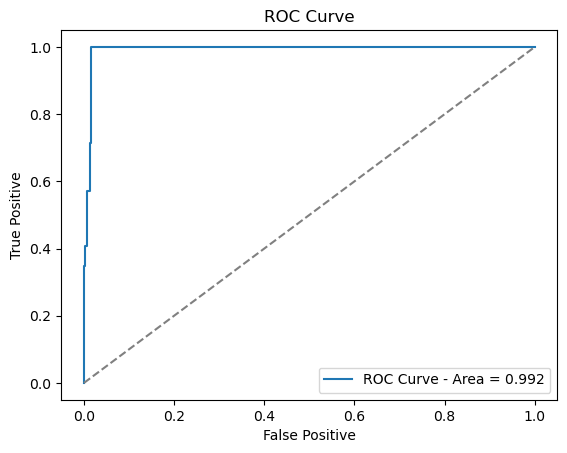

(<keras.src.callbacks.history.History at 0x33dcde320>,
 0.0719575583934784,
 0.9816666841506958,
 0.09963665902614594,
 0.9857142567634583)

In [78]:
# Single evaluation using a plain 60/35/5 split (≈60% train, 35% test, 5% validation)
# No synthetic features or resampling—only the engineered behavioral + categorical signals
standard_features = numeric_features + categorical_features

build_music_nn(
    name="FFNN - 60/35/5 split",
    features=standard_features,
    training=0.60,
    testing=0.35,
    validation=0.05,
    mini_batch_size=32,
    hidden_layers=[16, 8],
    epoch_cap=200,
    epoch_time=20,
    loss=True,
    matrix=True,
    roc=True
)


/var/folders/01/gv5k9r0x4lx4gqkn4nd4vkbw0000gn/T/ipykernel_58654/1084359367.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  frame[feature].fillna(frame[feature].median(), inplace=True)


Random Forest Baseline Accuracy : 0.986
              precision    recall  f1-score   support

     Not Pop       1.00      0.98      0.99       301
         Pop       0.91      1.00      0.95        49

    accuracy                           0.99       350
   macro avg       0.95      0.99      0.97       350
weighted avg       0.99      0.99      0.99       350



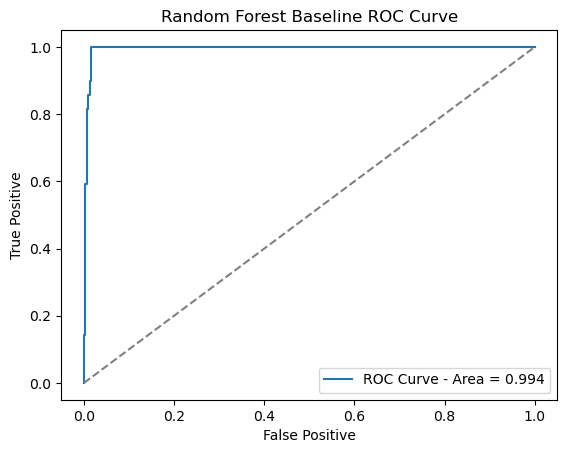

0.9943724998304969

In [79]:
# Random Forest baseline on the same real feature set for comparison
evaluate_random_forest(
    name="Random Forest Baseline",
    features=standard_features,
    training=0.60,
    testing=0.35,
    validation=0.05
)
